# Which Shortstop Converted the Most Outs Above Average?
## Chapter 1 Introduction
In this task, we will be working with a dataset which has one row per in-play ground ball event for a subset of Major League games. On the basis of this dataset, we will try to figure out which shortstop converted the most **Outs Above Average (OAA)**.

According to Statcast, **OAA** is a range-based metric of skill that shows how many outs a player has saved. For example, a fielder who catches a 25% **Out Probability** play gets +0.75; one who fails to make the play gets -0.25.

Therefore, in this task, we will develop a framework which is capable of estimating **Out Probability** for each in-play ground ball first fielded by shortstop and further calculating **OAA** for each shortstop.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from matplotlib.patches import Arc
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix

In [2]:
# Load the data
data = pd.read_excel('shortstopdefense.xlsx', sheet_name='TBJExercise')
variable = pd.read_excel('shortstopdefense.xlsx', sheet_name='Variable Dictionary')

## Chapter 2 Feature Preprocessing
Since our main purpose is to calculate **OAA** for each shortstop, we only select in-play ground ball event first fielded by shortstop from the given dataset in the first stage. After that, we 
check whether there are NaN values in the columns that will be used as features for estimating **Out Probability**. Finally, our final dataset contains 4721 in-play ground ball events.

In [3]:
# Select a subet of the given data
shortstop_data = data[data['fielded_pos']==6]
shortstop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4722 entries, 0 to 20146
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       4722 non-null   int64  
 1   playerid                 4722 non-null   int64  
 2   pos                      4722 non-null   int64  
 3   player_x                 4722 non-null   float64
 4   player_y                 4722 non-null   float64
 5   player_vx                4721 non-null   float64
 6   player_vy                4721 non-null   float64
 7   playtype                 4722 non-null   object 
 8   eventtype                4722 non-null   object 
 9   trajectory               4722 non-null   object 
 10  fielded_pos              4722 non-null   float64
 11  fieldingplay             4722 non-null   float64
 12  fielded_scoring          4722 non-null   object 
 13  player_out_credit        4722 non-null   bool   
 14  is_runnersgoing        

In [4]:
# Drop the NaN value
shortstop_data = shortstop_data.dropna(how='any',axis=0).reset_index()

Before directly starting to build predictive models, we are going to research which factors might be helpful in calculating **OAA** more accurately. According to [Tom Tango's article](http://tangotiger.com/images/uploads/History_of_the_Fielding.pdf?fbclid=IwAR3bIoMfjvaWd_l9ucYVCYRGCJxUHWApJx6I7aQG4KC4KQfBd1pSUvls4m4), the following four factors primarily affect the chance of a play being converted into an out for infielders:

1. How far the infielder has to go to reach the ball
2. How much time the infielder has to get there
3. How far the infielder is from the base the runner is heading to
4. How fast the runner is

Regarding the first factor, since we have shortstop's location at the moment the ball is hit and location for where the batted ball first landed, we could easily calculate distance that shortstop has to go to reach the ball, named as **distance_ball**. Regarding the second factor, since we have shortstop's velocity and distance that shortstop has to go to reach the ball, we could also easily calculate how much time the infielder has to get there, named as **moving_time**. Regarding the fourth factor, since we don't have detailed physical information about runner, we basically assume that all runners'speed are the same.

However, the third factor might be our biggest challenge. Since, from the given dataset, we don't know which base the shortstop would like to throw to, we first figure out every possible sequences of **fieldingplay** and then utilize **plattype**, **eventtype**, **fielded_scoring**, **player_out_credict**, **runner_on_first**, **runner_on_second**, and **runner_on_third** to speculate which base the shortstop would like to throw to against each possible sequence of **fieldingplay**.

Nevertheless, we find out that when the sequence of **fieldingplay** equals to **6, 67, 68, or 69**, the corresponding event result is bascially single, double, or error. In that case, it's ambiguous to specify which base the shortstop would like to throw to. Therefore, we decide to slightly transform the third factor. Instead of calcualting  how far the infielder is from the base the runner is heading to, we assume that all shortstops' arm strength are the same (i.e., 90 mph) and further calcuale how much time the infielder is from the base the runner is heading to. Hence, the definition of the modified third factor is how much time the shortstop handle the ball after reaching the ball, named as **handling_time**. Accordingly, when the sequence of **fieldingplay** equals to **6, 67, 68, or 69**, it's more reasonable to determine that the shortstop take zero seconds to deal with the ball after reaching the ball.

In [5]:
# Calculate distance between shortstop and ball
shortstop_data = shortstop_data.assign(distance_ball=lambda x: ((x['player_x']-x['landing_location_x'])**2+(x['player_y']-x['landing_location_y'])**2)**(0.5))
# Calculate moving speed
shortstop_data = shortstop_data.assign(moving_speed=lambda x: ((x['player_vx']**2)+(x['player_vy']**2))**(0.5))
# Calculate moving time
shortstop_data = shortstop_data.assign(moving_time=lambda x: x['distance_ball']/x['moving_speed'])

In [6]:
# Find every possible sequences of fieldingplay
shortstop_data.groupby('fieldingplay').size().reset_index().rename(columns={0:'count'})

,fieldingplay,count
0,6.0,589
1,61.0,2
2,62.0,19
3,63.0,3193
4,64.0,396
5,65.0,34
6,67.0,35
7,68.0,15
8,69.0,5
9,625.0,2


In [7]:
# Calculate handling time
location_1B = {'x': 45*(2**0.5), 'y': 45*(2**0.5)}
location_2B = {'x': 0, 'y': 90*(2**0.5)}
location_3B = {'x': -45*(2**0.5), 'y': 45*(2**0.5)}
location_HB = {'x': 0, 'y': 0}
average_throw_velocity = 90*(5280/3600) # convert 90 mph into 132 ft/s

def handling_time_function(data):
    
    time_list = []
    n = data.shape[0]
    for i in range(n):
        if data['fieldingplay'][i] in [6, 67, 68, 69, 672]:
            time_list.append(0)
        elif data['fieldingplay'][i] in [61, 63, 632, 635, 636]:
            distance = ((data['landing_location_x'][i]-location_1B['x'])**2+(data['landing_location_y'][i]-location_1B['y'])**2)**(0.5)
            time = distance/average_throw_velocity
            time_list.append(time)
        elif data['fieldingplay'][i] in [64, 642, 643, 645, 646, 6464, 653]:
            distance = ((data['landing_location_x'][i]-location_2B['x'])**2+(data['landing_location_y'][i]-location_2B['y'])**2)**(0.5)
            time = distance/average_throw_velocity
            time_list.append(time)
        elif data['fieldingplay'][i] in [65, 654, 656, 65256]:
            distance = ((data['landing_location_x'][i]-location_3B['x'])**2+(data['landing_location_y'][i]-location_3B['y'])**2)**(0.5)
            time = distance/average_throw_velocity
            time_list.append(time)
        elif data['fieldingplay'][i] in [62, 625, 626, 6251,6253, 6256]:
            distance = ((data['landing_location_x'][i]-location_HB['x'])**2+(data['landing_location_y'][i]-location_HB['y'])**2)**(0.5)
            time = distance/average_throw_velocity
            time_list.append(time)
            
    return time_list

handling_time = handling_time_function(shortstop_data)
shortstop_data = shortstop_data.assign(handling_time=handling_time)

## Chapter 3 Model Evaluation and Parameter Tuning
After features preprocessing, we are going to define our machine learning problem. Again, our purpose is to estimate **Out Probability** for each in-play ground ball first fielded by shortstop and further calculating **OAA** for each shortstop. In fact, on the basis of the given dataset, we don't have any information about **Out Probability** which could be used as a response variable.

However, we do have a critical variable named **player_out_credict** which represents whether the shortstop is given out credit on the play. Therefore, we would regard **player_out_credict** as a classification label and further consider our problem as a classification problem. After predicting whether the shortstop is given out credit on the play, we could further predict probabilities of the shortstop being given out credit on the play (i.e., **Out Probability**). Hence, in this chapter, we respectively use **Random Forest Classifier**, **k-NN Classifier**, and **XGBoost Classifier** to predict whether the shortstop is given out credit on the play given the features below:

1. distance_ball: how far the infielder has to go to reach the ball
2. moving_speed: how fast the shortstop is
3. moving_time: how much time the shortstop has to go to reach the ball
4. handling_time: how much time the shortstop handle the ball after reaching the ball
5. hang_time: the time until a batted ball reached the ground
6. launch_vert_ang: the intial vertical launch angle of the batted ball
7. launch_horiz_ang: the intial horizontal spray angle of the batted ball
8. launch_speed: the initial exit velocity of the batted ball

In addition, we use **Scikit-learn's Pipeline and GridSearchCV** to tune each model's parameters. Afterward, we compare each model's test accuracy and confusion matrix. Finally, we could verify that **Random Forest Classifier**  has similar performance to **XGBoost Classifier** and they both outperform **k-NN Classifier** on test accuracy and confusion matrix. Therefore, we are able to use **Random Forest Classifier** and **XGBoost Classifier** to predict **player_out_credict** and **Out Probability** later.

In [8]:
# Split the data into random train and test subsets
features = ['distance_ball', 'moving_speed', 'moving_time', 'handling_time',
            'launch_vert_ang', 'launch_horiz_ang', 'launch_speed', 'hang_time']
shortstop_data['player_out_credit'] = shortstop_data['player_out_credit'].astype(int)

X = shortstop_data[features].to_numpy()
y = shortstop_data[['player_out_credit']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.1 Random Forest Classifier

In [646]:
# Tune parameters for random forest classifier
pipe = Pipeline([('classifier', RandomForestClassifier())])
search_space = [{'classifier': [RandomForestClassifier(random_state=42)],
                 'classifier__n_estimators': [200, 600, 1000],
                 'classifier__max_features': ['auto', 'sqrt'],
                 'classifier__max_depth': [20, 60, 100, None],
                 'classifier__min_samples_split': [2, 5, 10],
                 'classifier__min_samples_leaf': [1, 2, 4]}]

clf = GridSearchCV(pipe, search_space, cv=5, verbose=0)
clf = clf.fit(X_train, y_train.ravel())

In [657]:
# Calculate test accuracy and confusion matrix for random forest classifier
rf_model = clf.best_estimator_['classifier']
rf_model.fit(X_train, y_train.ravel())
accuracy =  rf_model.score(X_test, y_test.ravel())
print("Test Accuracy: {}".format(accuracy))

y_pred = rf_model.predict(X_test)
cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("Confusion Matrix:")
print(cf_matrix)

Test Accuracy: 0.9862433862433863
Confusion Matrix:
[[136   6]
 [  7 796]]


### 3.2 K-NN Classifier

In [658]:
# Tune parameters for k-NN Classifier
pipe = Pipeline([('classifier', KNeighborsClassifier())])
search_space = [{'classifier': [KNeighborsClassifier(algorithm='auto')],
                 'classifier__n_neighbors': [5, 7, 9],
                 'classifier__weights': ['uniform', 'distance'],
                 'classifier__p': [1, 2]}]

clf = GridSearchCV(pipe, search_space, cv=5, verbose=0)
clf = clf.fit(X_train, y_train.ravel())

In [660]:
# Calculate test accuracy and confusion matrix for k-NN Classifier
knn_model = clf.best_estimator_['classifier']
knn_model.fit(X_train, y_train.ravel())
accuracy =  knn_model.score(X_test, y_test.ravel())
print("Test Accuracy: {}".format(accuracy))

y_pred = knn_model.predict(X_test)
cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("Confusion Matrix:")
print(cf_matrix)

Test Accuracy: 0.8539682539682539
Confusion Matrix:
[[  5 137]
 [  1 802]]


### 3.3 XGBoost Classifier

In [661]:
# Tune parameters for XGBoost Classifier
pipe = Pipeline([('classifier', XGBClassifier())])
search_space = [{'classifier': [XGBClassifier(random_state=42)],
                 'classifier__max_depth': [3, 6, 9],
                 'classifier__min_child_weight': [3, 6, 9],
                 'classifier__gamma': [0.1, 0.3, 0.5],
                 'classifier__colsample_bytree': [0.3, 0.6, 0.9]}]

clf = GridSearchCV(pipe, search_space, cv=5, verbose=0)
clf = clf.fit(X_train, y_train.ravel())

In [663]:
# Calculate test accuracy and confusion matrix for XGBoost Classifier
xgb_model = clf.best_estimator_['classifier']
xgb_model.fit(X_train, y_train.ravel())
accuracy =  xgb_model.score(X_test, y_test.ravel())
print("Test Accuracy: {}".format(accuracy))

y_pred = xgb_model.predict(X_test)
cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("Confusion Matrix:")
print(cf_matrix)

Test Accuracy: 0.9862433862433863
Confusion Matrix:
[[135   7]
 [  6 797]]


## Chapter 4 Feature importance and Classification Probability Calibration
According to the previous chapter, we find out that **Random Forest Classifier**  has similar performance to **XGBoost Classifier** and they both outperform **k-NN Classifier** on test accuracy and confusion matrix. Therefore, now we are able to use **Random Forest Classifier** and **XGBoost Classifier** to predict **player_out_credict** and **Out Probability**. 

Hence, in this chapter, we first figure out which features have siginificant impact on predicting **player_out_credict** by calculating feature importance. Regarding both **Random Forest Classifier** and **XGBoost Classifier**, it's obvious that **handling_time**, which represents how much time the shortstop handle the ball after reaching the ball, has the most siginificant impact on predicting **player_out_credict**.

After building the machine learning models and understanding the feature importance, we start to focus on which model has a better performance on predict **Out Probability** since both **Random Forest Classifier** and **XGBoost Classifier** achieve a test accuracy of 98.6% on predicting the classification labels, **player_out_credict**.

However, in classification tasks, test accuracy only measures how often we are correct and says nothing about how confident we are in being correct. As a result, classification models tend to have much weaker and more systematically biased probability prediction forecasts. Hence, in this chapter, we evaluate probability forecasting performances of both **Random Forest Classifier** and **XGBoost Classifier**. Besides, we try to fix our predicted **Out Probability** by calibrating both **Random Forest Classifier** and **XGBoost Classifier** using sigmoid and isotonic methods. 

In the blue, we have the calibration curve for the original **Random Forest Classifier** and **XGBoost Classifier**.
Meanwhile, in the yellow, we could see that the sigmoid adjusted probabilities are a little bit close to the true mean probabilities (i.e., gray dotted line). However, it seems that **XGBoost Classifier** calibrated by sigmoid method is a little bit better than **Random Forest Classifier** calibrated by sigmoid method since **Random Forest Classifier** calibrated by sigmoid method overshoots the high-probability data by too much. As a result, in the next chapter, we will use **XGBoost Classifier** calibrated by sigmoid method to predict **Out Probability** and further calculate **Outs Above Average**.

### 4.1 Random Forest Classifier

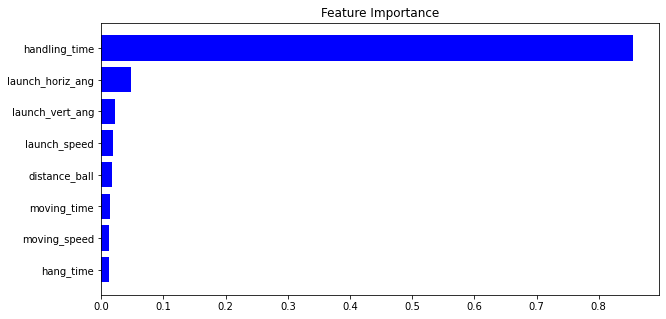

In [9]:
# Calculate feature importance for random forest classifier
rf_model = RandomForestClassifier(n_estimators=600, max_features='auto', max_depth=20, min_samples_split=2, min_samples_leaf=4, random_state=42)
rf_model.fit(X_train, y_train.ravel())
importances = rf_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()

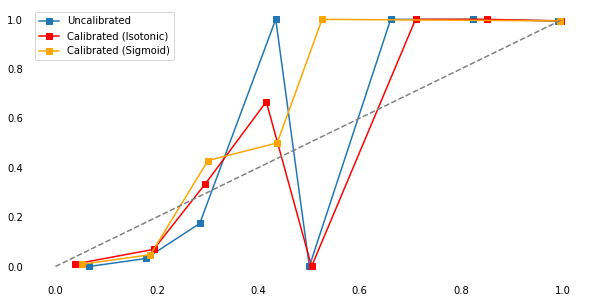

In [10]:
# Classification probability calibration for random forest classifier
fig, ax = plt.subplots(figsize=(10, 5))

# Uncalibrated
clf = RandomForestClassifier(n_estimators=600, max_features='auto', max_depth=20, min_samples_split=2, min_samples_leaf=4, random_state=42)
clf.fit(X_train, y_train.ravel())
y_test_predict_proba = clf.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=8)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Uncalibrated')

# Calibrated by isotonic method
clf_isotonic = CalibratedClassifierCV(clf, cv=3, method='isotonic')
clf_isotonic.fit(X_train, y_train.ravel())
y_test_predict_proba = clf_isotonic.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=8)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Calibrated (Isotonic)')

# Calibrated by sigmoid method
clf_sigmoid = CalibratedClassifierCV(clf, cv=3, method='sigmoid')
clf_sigmoid.fit(X_train, y_train.ravel())
y_test_predict_proba = clf_sigmoid.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=8)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='orange', label='Calibrated (Sigmoid)')

plt.plot([0, 1], [0, 1], '--', color='gray')
sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().legend()
plt.show()

### 4.2 XGBoost Classifier

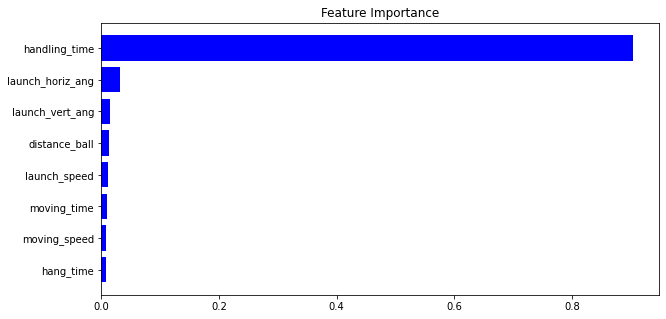

In [11]:
# Calculate feature importance for XGBoost classifier
xgb_model = XGBClassifier(max_depth=6, min_child_weight=9, gamma=0.1, colsample_bytree=0.6, random_state=42)
xgb_model.fit(X_train, y_train.ravel())
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.show()

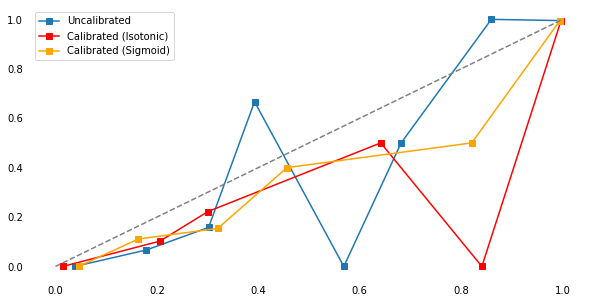

In [12]:
# Classification probability calibration for XGBoost classifier
fig, ax = plt.subplots(figsize=(10, 5))

# Uncalibrated
clf = XGBClassifier(max_depth=6, min_child_weight=9, gamma=0.1, colsample_bytree=0.6, random_state=42)
clf.fit(X_train, y_train.ravel())
y_test_predict_proba = clf.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=8)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Uncalibrated')

# Calibrated by isotonic method
clf_isotonic = CalibratedClassifierCV(clf, cv=5, method='isotonic')
clf_isotonic.fit(X_train, y_train.ravel())
y_test_predict_proba = clf_isotonic.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=8)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Calibrated (Isotonic)')

# Calibrated by sigmoid method
clf_sigmoid = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
clf_sigmoid.fit(X_train, y_train.ravel())
y_test_predict_proba = clf_sigmoid.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=8)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='orange', label='Calibrated (Sigmoid)')

plt.plot([0, 1], [0, 1], '--', color='gray')
sns.despine(left=True, bottom=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.gca().legend()
plt.show()

## Chpater 5 Outs above average Leaderboard
Now, we decide to use **XGBoost Classifier** calibrated by sigmoid method to predict **Out Probability** and further calculate **Outs Above Average**. Let's first recall what is **Outs Above Average**. According to Statcast, **Outs Above Average** is a range-based metric of skill that shows how many outs a player has saved. For example, a fielder who catches a 25% **Out Probability** play gets +0.75; one who fails to make the play gets -0.25. 

Therefore, on the basis of the definition, we first use **XGBoost Classifier** calibrated by sigmoid method to predict **Out Probability** for each in-play ground ball first fielded by shortstop and further calculating **Outs Above Average** for each shortstop. Finally, we have a leaderboard of **Outs Above Average** for shortstop including the playerid, number of opportunities, and the outs above average. From the leaderboard, we could recognize that the shortstop whose playerid equals to 162393 has the highest **Outs Above Average**, which equals to 3.67. Please refer to Appendix for the full leaderboard.

In [13]:
# Define a function to calculate out probability and oaa
def OAA_function(data, model):
    
    X = data[features].to_numpy()
    y = data[['player_out_credit']].to_numpy()
    y_predict_prob = model.predict_proba(X)[:,1]
    out_prob = y_predict_prob
    
    OAA_score = []
    n = len(y_predict_prob)
    for i in range(n):
        if y.ravel()[i] == 1:
            score = round(1-y_predict_prob[i], 2)
            OAA_score.append(score)
        elif y.ravel()[i] == 0:
            score = round(-y_predict_prob[i], 2)
            OAA_score.append(score)
    
    return out_prob, OAA_score

In [43]:
# Calculate out probability and oaa for each play
xgb_model = XGBClassifier(max_depth=6, min_child_weight=9, gamma=0.1, colsample_bytree=0.6, random_state=42)
xgb_sigmoid = CalibratedClassifierCV(xgb_model, cv=5, method='sigmoid')
xgb_sigmoid.fit(X_train, y_train.ravel())
OAA = OAA_function(shortstop_data, xgb_sigmoid)
shortstop_data = shortstop_data.assign(outs_above_average=OAA[1])
shortstop_data = shortstop_data.assign(out_probability=OAA[0])

In [44]:
# Build a leaderboard (the first one)
leaderboard = shortstop_data.groupby('playerid').agg({'outs_above_average': ['count', 'sum']}).reset_index()
leaderboard.columns = ['playerid', 'number of opportunities', 'outs above average']
leaderboard.sort_values(by='outs above average', ascending=False).reset_index(drop=True)[0:40]

,playerid,number of opportunities,outs above average
0,162393,148,3.67
1,167960,196,2.87
2,206311,133,1.78
3,154448,166,1.60
4,2087,62,1.06
5,9424,46,1.04
6,5393,129,0.86
7,9210,48,0.77
8,5419,129,0.76
9,169390,13,0.73


## Chapter 6 Shifting
Since now we understand how to calculate **Outs Above Average** and know exactly where each shortstop stands, which is helpful in a baseball world where shifting and out-of-position defenders are commonplace. Therefore, after visualizing each shortstop's location, we could easily recognize whether the shorstop is standing in regular spot or between the first base and the second base. Hence, It also allows for an further **Outs Above Average** breakdown.

In our case, when the shorstop is standing between the second base and the third base, we define this situation as **no shifting**. On the other hand, when the shorstop is standing between the first base and the second base, we define this situation as **shifting**. For example, from the previous chapter, the shortstop whose playerid equals to 162393 has **+3.67 OAA**. Due to shifting, this shortstop's **+3.67 OAA** actually breaks down into **+3.33 OAA** in regular spot and **+0.34 OAA** when shifting. Please also refer to Appendix for the full leaderboard.

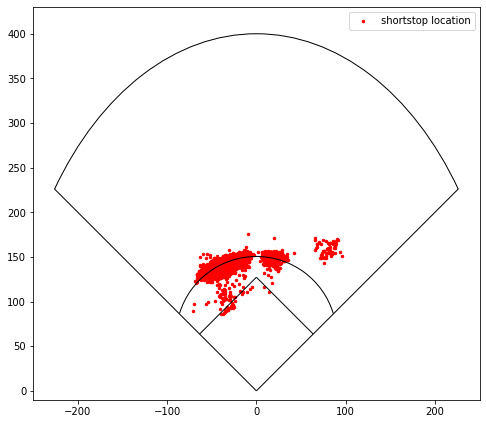

In [45]:
# Visualize each shortstop's location
x1 = shortstop_data['player_x']
y1 = shortstop_data['player_y']

lines = [[(location_HB['x'], location_HB['y']), (160*(2**0.5), 160*(2**0.5))],
         [(location_HB['x'], location_HB['y']), (-160*(2**0.5), 160*(2**0.5))],
         [(location_1B['x'], location_1B['y']), (location_2B['x'], location_2B['y'])],
         [(location_2B['x'], location_2B['y']), (location_3B['x'], location_3B['y'])]]
lc = mc.LineCollection(lines, colors='black', linewidths=1)
arc_element1 = Arc((0, 0), 548, 800, theta1=45, theta2=135, linewidth=1, color='black')
arc_element2 = Arc((0, 60.5), 180, 180, theta1=17, theta2=163, linewidth=1, color='black')

fig, ax = plt.subplots(figsize=(8,8))
ax.axis('scaled')
ax.set_xlim([-250, 250])
ax.set_ylim([-10, 430])
ax.add_collection(lc)
ax.add_patch(arc_element1)
ax.add_patch(arc_element2)
ax.scatter(x1, y1, color='red', alpha=1, s=6, label='shortstop location')
ax.legend()
plt.show()

In [46]:
# Define a function to check whether the shortstop shifts
def shift_function(data):
    
    shift = []
    n = data.shape[0]
    for i in range(n):
        if data['player_x'][i] >= 0:
            shift.append('shifting')
        elif data['player_x'][i] < 0:
            shift.append('no shifting')
            
    return shift

In [47]:
# Check whether the shortstop shifts
shift_or_not = shift_function(shortstop_data)
shortstop_data = shortstop_data.assign(shift_or_not=shift_or_not)

In [48]:
# Build a leaderboard (the second one)
raw_oaa_leaderboard = shortstop_data.groupby(['playerid', 'shift_or_not']).agg({'outs_above_average': ['sum', 'count']}).reset_index().droplevel(0,axis=1)
raw_oaa_leaderboard.columns = ['playerid', 'shifting', 'outs above average', 'number of opportunities']

oaa_leaderboard = pd.pivot_table(raw_oaa_leaderboard, values=['number of opportunities','outs above average'],
               index='playerid', columns='shifting', aggfunc=np.sum, fill_value=0).reset_index()
oaa_leaderboard.columns = oaa_leaderboard.columns.map(' | '.join).str.strip(' | ')

n = oaa_leaderboard['number of opportunities | no shifting'] + oaa_leaderboard['number of opportunities | shifting']
oaa_leaderboard.insert(loc=3, column='number of opportunities', value=n)
oaa_leaderboard['outs above average'] = oaa_leaderboard['outs above average | no shifting'] + oaa_leaderboard['outs above average | shifting']
oaa_leaderboard.sort_values(by='outs above average', ascending=False).reset_index(drop=True)[0:40]

,playerid,number of opportunities | no shifting,number of opportunities | shifting,number of opportunities,outs above average | no shifting,outs above average | shifting,outs above average
0,162393,121,27,148,3.33,0.34,3.67
1,167960,176,20,196,1.90,0.97,2.87
2,206311,127,6,133,1.72,0.06,1.78
3,154448,138,28,166,1.21,0.39,1.60
4,2087,48,14,62,1.13,-0.07,1.06
5,9424,42,4,46,1.05,-0.01,1.04
6,5393,109,20,129,1.04,-0.18,0.86
7,9210,44,4,48,0.73,0.04,0.77
8,5419,112,17,129,0.67,0.09,0.76
9,169390,10,3,13,0.70,0.03,0.73


## Chapter 7 Out Probability
After building the leaderboard of **Outs Above Average** for each shortstop, we are interested in focusing on each shortstop's performance. According to the leaderboard in the previous chapter, we are really curious about why the shorstop (id: 162393) and the shortstop (id: 162648) have such difference in **OAA**. In detail, given that they have similar number of opportunities, the shorstop (id: 162393) has **+3.67 OAA** while the shortstop (id: 162648) only has **+0.14 OAA**.

Therefore, we decide to visualize every locations for where the batted ball first landed sperately for these two shortstops. However, on the basis of the two scatter plots, there is no essential difference. Hence, we start to recall the definition of **Outs Above Average**. That is, a fielder who catches a 25% **Out Probability** play gets +0.75; one who fails to make the play gets -0.25.

As a result, we speculate that the shorstop (id: 162393) might be given out credits on more plays which have low **Out Probability**. Hence, we decide to separate each play's **Out Probability** into 5 groups. In detail,**Out Probability** larger than 80% would be groups 5; **Out Probability** between 60% and 80% would be groups 4; **Out Probability** between 40% and 60% would be groups 3; **Out Probability** between 20% and 40% would be groups 2; **Out Probability** less than 20% would be groups 1.

Consequently, we build a new leaderboard of **Outs Above Average** including the playerid, the outs above average,  number of opportunities for each group, number of success for each group, and success rate for each group. According to the new leaderboard, we could figure that the reason that shorstop (id: 162393) has the highest **OAA**  is that  he is given out credits on more plays whose **Out Probability** are lower than 60%. Please also refer to Appendix for the full leaderboard.

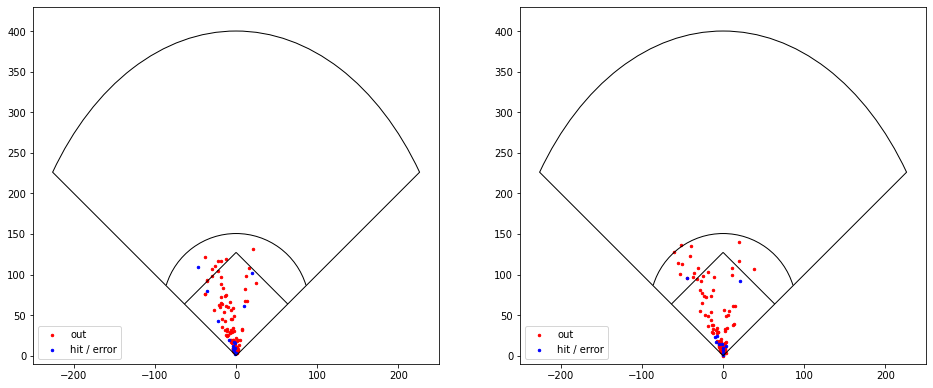

In [51]:
# Visualize landing location for shortstop 162393 and 162648
compared_id = [162393, 162648]

fig, ax = plt.subplots(1, 2, figsize=(16,8))
for i in range(len(compared_id)):
    
    lines = [[(location_HB['x'], location_HB['y']), (160*(2**0.5), 160*(2**0.5))],
             [(location_HB['x'], location_HB['y']), (-160*(2**0.5), 160*(2**0.5))],
             [(location_1B['x'], location_1B['y']), (location_2B['x'], location_2B['y'])],
             [(location_2B['x'], location_2B['y']), (location_3B['x'], location_3B['y'])]]
    lc = mc.LineCollection(lines, colors='black', linewidths=1)
    arc_element1 = Arc((0, 0), 548, 800, theta1=45, theta2=135, linewidth=1, color='black')
    arc_element2 = Arc((0, 60.5), 180, 180, theta1=17, theta2=163, linewidth=1, color='black')
  
    x1 = shortstop_data[(shortstop_data['playerid']==compared_id[i]) & (shortstop_data['player_out_credit']==1)]['landing_location_x']
    y1 = shortstop_data[(shortstop_data['playerid']==compared_id[i]) & (shortstop_data['player_out_credit']==1)]['landing_location_y']
    x2 = shortstop_data[(shortstop_data['playerid']==compared_id[i]) & (shortstop_data['player_out_credit']==0)]['landing_location_x']
    y2 = shortstop_data[(shortstop_data['playerid']==compared_id[i]) & (shortstop_data['player_out_credit']==0)]['landing_location_y']
    
    ax[i].axis('scaled')
    ax[i].set_xlim([-250, 250])
    ax[i].set_ylim([-10, 430])
    ax[i].add_collection(lc)
    ax[i].add_patch(arc_element1)
    ax[i].add_patch(arc_element2)
    ax[i].scatter(x1, y1, color='red', alpha=1, s=6, label='out')
    ax[i].scatter(x2, y2, color='blue', alpha=1, s=6, label='hit / error')
    ax[i].legend()
plt.show()

In [52]:
# Define a function to separte each play's out probability into 5 groups
def out_probability_group_function(data):
    
    group = []
    n = data.shape[0]
    for i in range(n):
        if data['out_probability'][i] < 0.2:
            group.append('group 1')
        elif (data['out_probability'][i] >= 0.2) & (data['out_probability'][i] < 0.4):
            group.append('group 2')
        elif (data['out_probability'][i] >= 0.4) & (data['out_probability'][i] < 0.6):
            group.append('group 3')
        elif (data['out_probability'][i] >= 0.6) & (data['out_probability'][i] < 0.8):
            group.append('group 4')
        elif data['out_probability'][i] >= 0.8:
            group.append('group 5')
    return group

In [53]:
# Separte each play's out probability into 5 groups
out_probability_group = out_probability_group_function(shortstop_data)
shortstop_data = shortstop_data.assign(out_probability_group=out_probability_group)


In [54]:
# Build a leaderboard (the third one)
raw_out_prob_leaderboard = shortstop_data.groupby(['playerid', 'out_probability_group']).agg({'player_out_credit': ['sum', 'count'], 'outs_above_average': 'sum'}).reset_index()#.droplevel(0,axis=1)
raw_out_prob_leaderboard.columns = ['playerid', 'out probability group', 'number of success', 'number of opportunities', 'outs above average']

out_prob_leaderboard = pd.pivot_table(raw_out_prob_leaderboard, values=['number of success', 'number of opportunities', 'outs above average'],
               index='playerid', columns='out probability group', aggfunc=np.sum, fill_value=0).reset_index()
out_prob_leaderboard.columns = out_prob_leaderboard.columns.map(' | '.join).str.strip(' | ')

out_prob_leaderboard['outs above average'] = out_prob_leaderboard['outs above average | group 1'] + out_prob_leaderboard['outs above average | group 2'] + out_prob_leaderboard['outs above average | group 3'] + out_prob_leaderboard['outs above average | group 4'] + out_prob_leaderboard['outs above average | group 5']
out_prob_leaderboard.drop(['outs above average | group 1', 'outs above average | group 2', 'outs above average | group 3', 'outs above average | group 4', 'outs above average | group 5'], axis=1)

out_prob_leaderboard = out_prob_leaderboard[['playerid',
                                             'number of success | group 1',
                                             'number of opportunities | group 1',
                                             'number of success | group 2',
                                             'number of opportunities | group 2',
                                             'number of success | group 3',
                                             'number of opportunities | group 3',
                                             'number of success | group 4',
                                             'number of opportunities | group 4',
                                             'number of success | group 5',
                                             'number of opportunities | group 5',
                                             'outs above average']]

for i in range(1,6):
    r = round(out_prob_leaderboard['number of success | group {}'.format(6-i)]*100/out_prob_leaderboard['number of opportunities | group {}'.format(6-i)], 2)
    out_prob_leaderboard.insert(loc=13-2*i, column='success rate | group {}'.format(6-i), value=r)

out_prob_leaderboard.fillna(0).sort_values(by='outs above average', ascending=False).reset_index(drop=True)[0:40]

,playerid,number of success | group 1,number of opportunities | group 1,success rate | group 1,number of success | group 2,number of opportunities | group 2,success rate | group 2,number of success | group 3,number of opportunities | group 3,success rate | group 3,number of success | group 4,number of opportunities | group 4,success rate | group 4,number of success | group 5,number of opportunities | group 5,success rate | group 5,outs above average
0,162393,1,12,8.33,2,5,40.0,3,3,100.0,0,0,0.0,128,128,100.00,3.67
1,167960,0,26,0.00,3,3,100.0,2,2,100.0,0,0,0.0,164,165,99.39,2.87
2,206311,2,21,9.52,0,2,0.0,1,1,100.0,0,0,0.0,109,109,100.00,1.78
3,154448,0,16,0.00,1,2,50.0,1,1,100.0,0,0,0.0,147,147,100.00,1.60
4,2087,0,8,0.00,0,0,0.0,2,2,100.0,0,0,0.0,52,52,100.00,1.06
5,9424,0,4,0.00,1,1,100.0,0,0,0.0,0,0,0.0,41,41,100.00,1.04
6,5393,0,12,0.00,1,4,25.0,1,1,100.0,0,0,0.0,112,112,100.00,0.86
7,9210,0,10,0.00,1,1,100.0,0,0,0.0,0,0,0.0,37,37,100.00,0.77
8,5419,0,15,0.00,0,0,0.0,0,0,0.0,1,1,100.0,113,113,100.00,0.76
9,169390,0,2,0.00,1,1,100.0,0,0,0.0,0,0,0.0,10,10,100.00,0.73


## Chapter 8 Conclusions
In this task, in order to estimate **Out Probability** for each in-play ground ball first fielded by shortstop and further calculating **Outs Above Average** for each shortstop, we basically develop a reliable framework including creating features, building predictive models, tuning parameters, evaluating the models, calculating feature importance, building **Outs Above Average** leadboards and trying to get some insights from the leadboards.

Apparently, infielders pose a more complex challenge than outfielders on calculating **Outs Above Average** since we have to consider more situations on the field. For example, runner speed and double plays are still not considered in this task. Therefore, we truly believe that we could keep improving and developing our framework in the future once we get more data and better understand how every potential factors affect **Out Probability** and **Outs Above Average**.